# Granular Demand Forecast

This notebook walks through each step to create more granular, product-level forecasts using FB's prophet library. </br>
</br>
General workflow is as follows:
1. Create top line forecast to use as regressor later on
2. Create size-specific forecasts
3. ...


In [2127]:
import os
import yaml
import datetime
from datetime import datetime, timedelta
import psycopg2
import pandas as pd
import numpy as np
import urllib.request
from ipywidgets import interactive
from functools import reduce
from IPython.display import display
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.utilities import regressor_coefficients
from sqlalchemy import text
from sqlalchemy import create_engine

In [2128]:
# setting WD
os.chdir('/Users/Daniel.Kwon/projects')

In [2129]:
# database connection info
with open("./redshift_credentials.yml", 'r') as stream:
    try:
        rs_cred = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
engine_url = "postgresql://{user_name}:{pw}@{host}:{port}/{db_name}".format(user_name = rs_cred['default']['user'],
                                                                            pw        = urllib.parse.quote_plus(rs_cred['default']['password']),
                                                                            host      = rs_cred['default']['host'],
                                                                            port      = rs_cred['default']['port'],
                                                                            db_name   = rs_cred['default']['dbname']
                                                                           )
engine = create_engine(engine_url)

In [2188]:
# query
query = open('./granular-demand-forecast/sql/rug_sales.sql', 'r')
query_text = text(query.read())
df_sales = pd.read_sql_query(query_text, engine)

# get ad spend
df_spend = pd.read_csv('./granular-demand-forecast/ad_spend.csv')

# get marketing events
df_event = pd.read_csv('./granular-demand-forecast/marketing_events.csv')

# log transform regressor
df_spend['log_total_weekly_spend'] = np.log(df_spend['total_weekly_spend']+1)

# log transform y
df_sales['log_total_rugs_sold'] = np.log(df_sales['total_rugs_sold']+1)

# merge df
df_spend['week_begin_date']=pd.to_datetime(df_spend['week_begin_date'])
df_event['week_begin_date']=pd.to_datetime(df_event['week_begin_date'])
df_sales['week_begin_date']=pd.to_datetime(df_sales['week_begin_date'])
df_sales = df_sales.merge(df_spend, how='inner', on='week_begin_date')
df_sales = df_sales.merge(df_event, how='inner', on='week_begin_date')

## Creating Top Line Forecast

Forecast total number of rugs for use as inputs for other forecasts

In [2145]:
df_test = df_sales.loc[(df_sales['product_type']=='Rug'),
                       ['week_begin_date',
                        'total_rugs_sold',
                        'log_total_rugs_sold',
                        'total_weekly_spend',
                        'log_total_weekly_spend',
                        'google_and_bing_weekly_spend',
                        'sale',
                        'launch',
                        'bfcm',
                        'anniversary',
                        'spring',
                        'nynh',
                        'memorial_day',
                        'email',
                        'test']].rename(columns={'week_begin_date': 'ds',
                                                 'total_rugs_sold': 'y'})

In [2146]:
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.01)

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_weekly_spend',mode='multiplicative')
m.add_regressor('sale')
m.add_regressor('launch')
m.add_regressor('bfcm')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df_test)

In [2147]:
df_cv = cross_validation(m, initial='110 W', period='1 W', horizon = '12 W')

INFO:prophet:Making 13 forecasts with cutoffs between 2021-02-15 00:00:00 and 2021-05-10 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

In [2148]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,4.001349e+08,20003.372444,19240.544185,0.504625,0.522904,0.394047,0.010256
1,21 days,4.460349e+08,21119.538323,20203.027802,0.522734,0.618043,0.403093,0.000000
2,28 days,4.567104e+08,21370.783670,20260.574087,0.530688,0.526874,0.406434,0.000000
3,35 days,5.009599e+08,22382.134496,21459.167551,0.572383,0.568838,0.434846,0.066667
4,42 days,5.434852e+08,23312.768221,22507.707170,0.610723,0.603876,0.458594,0.010256


In [2149]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_spend[['week_begin_date',
                                'total_weekly_spend']], 
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email'
                               ]],
                      left_on='ds', right_on='week_begin_date')
forecast = m.predict(future)

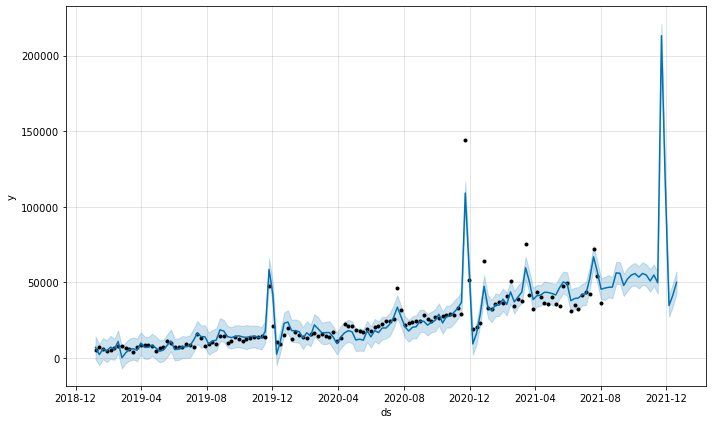

In [2152]:
fig = m.plot(forecast)

In [2153]:
df_top_line = forecast[['ds', 'yhat']]
df_top_line = df_top_line.merge(df_test[['ds','y']], how='left', on='ds')
df_top_line['y_merged'] = df_top_line.y.combine_first(df_top_line.yhat)

## Granular Forecasts

In [2206]:
# function + texture
query = open('./granular-demand-forecast/sql/rug_sales_function-texture.sql', 'r')
query_text = text(query.read())
df_sales_FT = pd.read_sql_query(query_text, engine)
df_sales_FT['week_begin_date']=pd.to_datetime(df_sales_FT['week_begin_date'])
df_sales_FT = df_sales_FT.merge(df_event, how='inner', on='week_begin_date')

In [2207]:
# function + texture + size
query = open('./granular-demand-forecast/sql/rug_sales_function-texture-size.sql', 'r')
query_text = text(query.read())
df_sales_FTS = pd.read_sql_query(query_text, engine)
df_sales_FTS['week_begin_date']=pd.to_datetime(df_sales_FTS['week_begin_date'])
df_sales_FTS = df_sales_FTS.merge(df_event, how='inner', on='week_begin_date')

### Indoor Chenille

In [2225]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Indoor') &
                     (df_sales_FT['texture']=='Chenille'),
                     ['week_begin_date',
                      'percent_of_total',
                      'total_rugs_sold',
                      'sale',
                      'launch',
                      'bfcm',
                      'anniversary',
                      'spring',
                      'email']].rename(columns={'week_begin_date': 'ds',
                                                'percent_of_total': 'y'})

In [2226]:
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False)

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

# CV resulting model
df_cv = cross_validation(m, initial='110 W', period='1 W', horizon = '12 W')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 13 forecasts with cutoffs between 2021-02-15 00:00:00 and 2021-05-10 00:00:00


  0%|          | 0/13 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,14 days,0.000468,0.021630,0.017862,0.020297,0.012876,0.020058,0.538462
1,21 days,0.000353,0.018776,0.015855,0.017965,0.014325,0.017810,0.605128
2,28 days,0.000311,0.017647,0.014565,0.016525,0.014152,0.016401,0.548718
3,35 days,0.000379,0.019456,0.015641,0.017789,0.015057,0.017658,0.471795
4,42 days,0.000415,0.020362,0.016115,0.018358,0.011809,0.018243,0.528205


In [2227]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_top_line[['ds','y_merged']], on='ds').rename(columns={'y_merged': 'total_rugs_sold'})
forecast = m.predict(future)

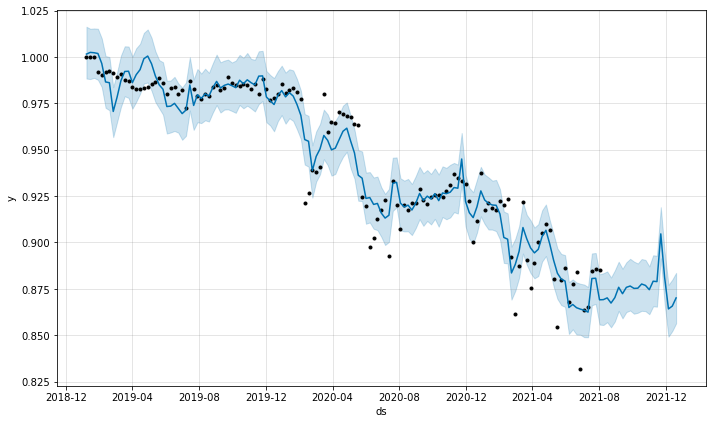

In [2228]:
fig = m.plot(forecast)

In [2229]:
df_IndoorChenille = forecast[['ds', 'yhat']]
df_IndoorChenille = df_IndoorChenille.merge(df[['ds','y']], how='left', on='ds')
df_IndoorChenille['y_merged'] = df_IndoorChenille.y.combine_first(df_IndoorChenille.yhat)
df_IndoorChenille = df_IndoorChenille.rename(columns={'yhat':'forecast',
                                                      'y':'actual',
                                                      'y_merged':'merged'})

#### Loop Through Sizes

In [2238]:
model_parameters = {'2x3':[False,0.05,'flat'],
                    '2.5x7':[True,0.05,'linear'],
                    '2.5x10':[True,0.05,'linear'],
                    '3x5':[True,0.05,'linear'],
                    '5x7':[True,0.05,'linear'],
                    '6x9':[True,0.05,'linear'],
                    '8x10':[False,0.05,'flat'],
                    '9x12':[False,0.05,'flat'],
                    '6" Round':[False,0.05,'flat'],
                    '8" Round':[True,0.05,'flat']
                   }

df_forecasts = pd.DataFrame(columns = ['ds','yhat','y','y_merged','size'])

for i in model_parameters.items():
    # define column names
    columns = ['week_begin_date',
               'percent_of_total',
               'total_rugs_sold',
               'sale',
               'launch',
               'bfcm',
               'anniversary',
               'spring',
               'email']
    columns.append(i[0])
    # create df
    df = df_sales_FTS.loc[(df_sales_FTS['function']=='Indoor') &
                          (df_sales_FTS['texture']=='Chenille') &
                          (df_sales_FTS['size']==i[0]),columns].rename(columns={'week_begin_date':'ds',
                                                                                'percent_of_total': 'y'})
    df = df.merge(df_IndoorChenille, how='inner', on='ds')
    df = df.rename(columns={'merged':'IndoorChenille_percentOfTotal'})
    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][0],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][1],
                growth=i[1][2])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    m.add_regressor('IndoorChenille_percentOfTotal')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    m.add_regressor('email')
    m.add_regressor(i[0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_IndoorChenille[['ds','merged']], on='ds').rename(columns={'merged': 'IndoorChenille_percentOfTotal'})
    # create forecast
    forecast = m.predict(future)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[0]
    df_outputs['function'] = "Indoor"
    df_outputs['texture'] = "Chenille"
    df_forecasts = df_forecasts.append(df_outputs)

INFO:prophet:n_changepoints greater than number of observations. Using 6.


### Outdoor Chenille

In [2231]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Outdoor') &
                     (df_sales_FT['texture']=='Chenille'),
                     ['week_begin_date',
                      'percent_of_total',
                      'total_rugs_sold',
                      'sale',
                      'launch',
                      'bfcm',
                      'anniversary',
                      'spring',
                      'email',
                      'outdoor']].rename(columns={'week_begin_date':'ds',
                                                  'percent_of_total':'y'})

In [2232]:
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.06,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('outdoor')

# train model
m.fit(df)

# CV resulting model
df_cv = cross_validation(m, initial='52 W', period='1 W', horizon = '4 W')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 7 forecasts with cutoffs between 2021-05-24 00:00:00 and 2021-07-05 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000239,0.015453,0.015154,0.371801,0.349306,0.328734,0.000000
1,14 days,0.000253,0.015903,0.014930,0.408444,0.437700,0.332261,0.000000
2,21 days,0.000239,0.015450,0.014482,0.421617,0.445668,0.343715,0.142857
3,28 days,0.000209,0.014463,0.013684,0.441089,0.451274,0.357346,0.000000


In [2233]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'anniversary',
                                'spring',
                                'email',
                                'outdoor']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_top_line[['ds','y_merged']], on='ds').rename(columns={'y_merged': 'total_rugs_sold'})
forecast = m.predict(future)

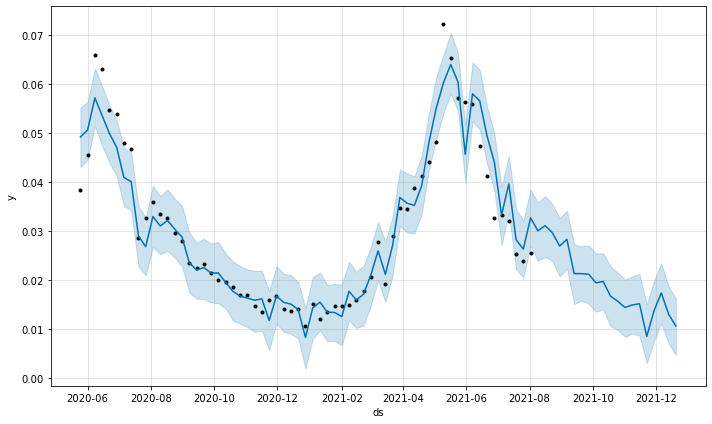

In [2234]:
fig = m.plot(forecast)

In [2235]:
df_OutdoorChenille = forecast[['ds', 'yhat']]
df_OutdoorChenille = df_OutdoorChenille.merge(df[['ds','y']], how='left', on='ds')
df_OutdoorChenille['y_merged'] = df_OutdoorChenille.y.combine_first(df_OutdoorChenille.yhat)
df_OutdoorChenille = df_OutdoorChenille.rename(columns={'yhat':'forecast',
                                                        'y':'actual',
                                                        'y_merged':'merged'})

#### Loop Through Sizes

In [2241]:
model_parameters = {'2.5x7':[True,0.06,'flat'],
                    '2.5x10':[True,0.06,'flat'],
                    '3x5':[True,0.05,'flat'],
                    '5x7':[True,0.05,'flat'],
                    '6x9':[True,0.05,'flat'],
                    '8x10':[True,0.05,'flat']
                   }

for i in model_parameters.items():
    # define column names
    columns = ['week_begin_date',
               'percent_of_total',
               'total_rugs_sold',
               'sale',
               'launch',
               'bfcm',
               'anniversary',
               'spring',
               'email']
    columns.append(i[0])
    # create df
    df = df_sales_FTS.loc[(df_sales_FTS['function']=='Outdoor') &
                          (df_sales_FTS['texture']=='Chenille') &
                          (df_sales_FTS['size']==i[0]),columns].rename(columns={'week_begin_date':'ds',
                                                                                'percent_of_total': 'y'})
    df = df.merge(df_OutdoorChenille, how='inner', on='ds')
    df = df.rename(columns={'merged':'OutdoorChenille_percentOfTotal'})
    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][0],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][1],
                growth=i[1][2])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    m.add_regressor('OutdoorChenille_percentOfTotal')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    m.add_regressor('email')
    m.add_regressor(i[0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_OutdoorChenille[['ds','merged']], on='ds').rename(columns={'merged': 'OutdoorChenille_percentOfTotal'})
    # create forecast
    forecast = m.predict(future)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[0]
    df_outputs['function'] = "Outdoor"
    df_outputs['texture'] = "Chenille"
    df_forecasts = df_forecasts.append(df_outputs)

### Plush

In [2245]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Indoor') &
                     (df_sales_FT['texture']=='Plush'),
                     ['week_begin_date',
                      'percent_of_total',
                      'total_rugs_sold',
                      'sale',
                      'launch',
                      'bfcm',
                      'anniversary',
                      'spring',
                      'email']].rename(columns={'week_begin_date': 'ds',
                                                'percent_of_total': 'y'})

In [2256]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

# CV resulting model
df_cv = cross_validation(m, initial='52 W', period='1 W', horizon = '1 W')
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Making 3 forecasts with cutoffs between 2021-07-12 00:00:00 and 2021-07-26 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000032,0.005623,0.004969,0.207623,0.12369,0.190995,1.0


In [2257]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                'outdoor']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_top_line[['ds','y_merged']], on='ds').rename(columns={'y_merged': 'total_rugs_sold'})
forecast = m.predict(future)

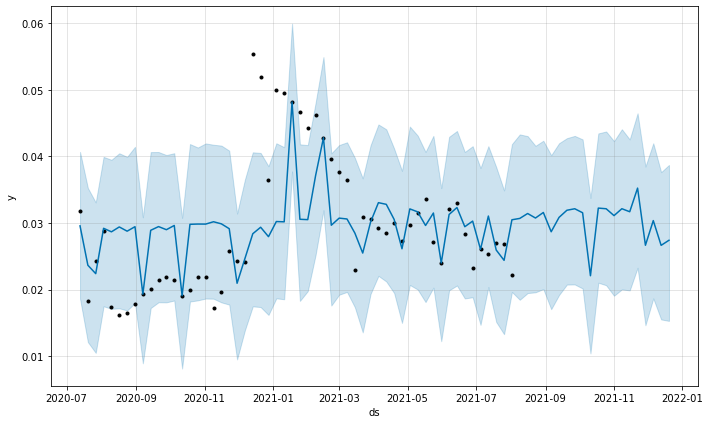

In [2258]:
fig = m.plot(forecast)

In [2259]:
df_IndoorPlush = forecast[['ds', 'yhat']]
df_IndoorPlush = df_IndoorPlush.merge(df[['ds','y']], how='left', on='ds')
df_IndoorPlush['y_merged'] = df_IndoorPlush.y.combine_first(df_IndoorPlush.yhat)
df_IndoorPlush = df_IndoorPlush.rename(columns={'yhat':'forecast',
                                                'y':'actual',
                                                'y_merged':'merged'})

#### Loop Through Sizes

In [2289]:
model_parameters = {'2x3':[False,0.001,'flat'],
                    '2.5x7':[False,0.05,'flat'],
                    '2.5x10':[False,0.05,'linear'],
                    '3x5':[False,0.05,'linear'],
                    '5x7':[False,0.05,'linear'],
                    '6x9':[False,0.05,'linear']
                   }

for i in model_parameters.items():
    # define column names
    columns = ['week_begin_date',
               'percent_of_total',
               'total_rugs_sold',
               'sale',
               'launch',
               'bfcm',
               'anniversary',
               'spring',
               'email']
    columns.append(i[0])
    # create df
    df = df_sales_FTS.loc[(df_sales_FTS['function']=='Indoor') &
                          (df_sales_FTS['texture']=='Plush') &
                          (df_sales_FTS['size']==i[0]),columns].rename(columns={'week_begin_date':'ds',
                                                                                'percent_of_total': 'y'})
    df = df.merge(df_IndoorPlush, how='inner', on='ds')
    df = df.rename(columns={'merged':'IndoorPlush_percentOfTotal'})
    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][0],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][1],
                growth=i[1][2])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    m.add_regressor('IndoorPlush_percentOfTotal')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    m.add_regressor('email')
    m.add_regressor(i[0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_IndoorPlush[['ds','merged']], on='ds').rename(columns={'merged': 'IndoorPlush_percentOfTotal'})
    # create forecast
    forecast = m.predict(future)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[0]
    df_outputs['function'] = "Indoor"
    df_outputs['texture'] = "Plush"
    df_forecasts = df_forecasts.append(df_outputs)

INFO:prophet:n_changepoints greater than number of observations. Using 4.


### Jute

In [2295]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Outdoor') &
                     (df_sales_FT['texture']=='Jute'),
                     ['week_begin_date',
                      'percent_of_total',
                      'total_rugs_sold',
                      'sale',
                      'launch',
                      'bfcm',
                      'anniversary',
                      'spring',
                      'email']].rename(columns={'week_begin_date': 'ds',
                                                'percent_of_total': 'y'})

In [2298]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.06,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
#m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 8.


In [2299]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_top_line[['ds','y_merged']], on='ds').rename(columns={'y_merged': 'total_rugs_sold'})
forecast = m.predict(future)

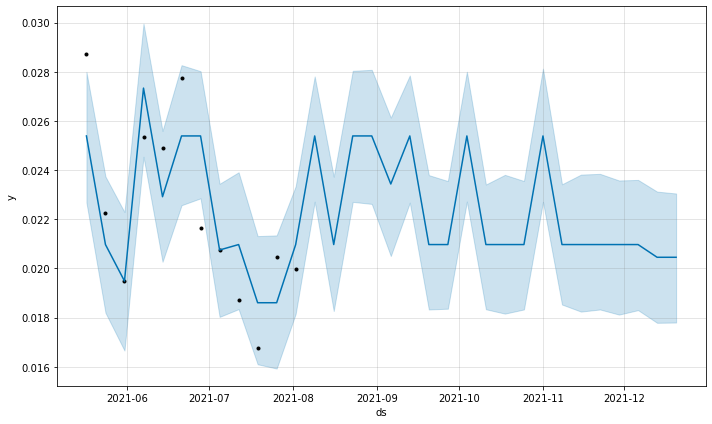

In [2301]:
fig = m.plot(forecast)

In [2302]:
df_Jute = forecast[['ds', 'yhat']]
df_Jute = df_Jute.merge(df[['ds','y']], how='left', on='ds')
df_Jute['y_merged'] = df_Jute.y.combine_first(df_Jute.yhat)
df_Jute = df_Jute.rename(columns={'yhat':'forecast',
                                  'y':'actual',
                                  'y_merged':'merged'})

#### Loop Through Sizes

In [2304]:
model_parameters = {'2.5x7':[False,0.05,'flat'],
                    '2.5x10':[False,0.05,'flat'],
                    '3x5':[False,0.05,'flat'],
                    '5x7':[False,0.05,'flat']
                   }

for i in model_parameters.items():
    # define column names
    columns = ['week_begin_date',
               'percent_of_total',
               'total_rugs_sold',
               'sale',
               'launch',
               'bfcm',
               'anniversary',
               'spring',
               'email']
    columns.append(i[0])
    # create df
    df = df_sales_FTS.loc[(df_sales_FTS['function']=='Outdoor') &
                          (df_sales_FTS['texture']=='Jute') &
                          (df_sales_FTS['size']==i[0]),columns].rename(columns={'week_begin_date':'ds',
                                                                                'percent_of_total': 'y'})
    df = df.merge(df_Jute, how='inner', on='ds')
    df = df.rename(columns={'merged':'Jute_percentOfTotal'})
    # specify model parameters
    m = Prophet(yearly_seasonality=i[1][0],
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=i[1][1],
                growth=i[1][2])
    # add holidays and regressors
    m.add_country_holidays(country_name='US')
    m.add_regressor('Jute_percentOfTotal')
    m.add_regressor('sale',mode='multiplicative')
    m.add_regressor('launch',mode='multiplicative')
    m.add_regressor('bfcm',mode='multiplicative')
    m.add_regressor('anniversary',mode='multiplicative')
    m.add_regressor('spring')
    m.add_regressor('email')
    m.add_regressor(i[0])
    # train model
    m.fit(df)
    # make future df
    future = m.make_future_dataframe(periods=52,freq = 'W-MON')
    future = future.merge(df_event,left_on='ds', right_on='week_begin_date')
    future = future.merge(df_Jute[['ds','merged']], on='ds').rename(columns={'merged': 'Jute_percentOfTotal'})
    # create forecast
    forecast = m.predict(future)
    # create df with forecasts
    df_outputs = forecast[['ds', 'yhat']]
    df_outputs = df_outputs.merge(df[['ds','y']], how='left', on='ds')
    df_outputs['y_merged'] = df_outputs.y.combine_first(df_outputs.yhat)
    df_outputs['size'] = i[0]
    df_outputs['function'] = "Outdoor"
    df_outputs['texture'] = "Jute"
    df_forecasts = df_forecasts.append(df_outputs)

INFO:prophet:n_changepoints greater than number of observations. Using 8.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:n_changepoints greater than number of observations. Using 7.


### Doormat

In [1636]:
df = df_sales_FTS.loc[(df_sales_FTS['function']=='Doormat') &
                      (df_sales_FTS['texture']=='Bristle') &
                      (df_sales_FTS['size']=='2x3'),
                      ['week_begin_date',
                       'percent_of_total',
                       'total_rugs_sold',
                       'sale',
                       'launch',
                       'bfcm',
                       'anniversary',
                       'spring',
                       'email',
                       'doormat']].rename(columns={'week_begin_date': 'ds',
                                                   'percent_of_total': 'y'})
df = df.merge(df_IndoorChenille, how='inner', on='ds')
df = df.rename(columns={'merged':'IndoorChenille_percentOfTotal'})

In [1637]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
#m.add_regressor('IndoorChenille_percentOfTotal')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('doormat')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 9.


In [1638]:
df_cv = cross_validation(m, initial='26 W', period='1 W', horizon = '1 W')

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.

In [1639]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000003,0.001655,0.001313,0.124861,0.085897,0.124058,0.285714
1,14 days,0.000004,0.001889,0.001563,0.141606,0.134046,0.152685,0.285714
2,21 days,0.000002,0.001318,0.001078,0.111313,0.104467,0.121167,0.285714
3,28 days,0.000006,0.002445,0.001938,0.206138,0.189498,0.191304,0.285714


In [1640]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                'doormat']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_IndoorChenille[['ds','merged']], on='ds').rename(columns={'merged': 'IndoorChenille_percentOfTotal'})

In [1641]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
29,2021-11-22,0.044938,0.031236,0.059326
30,2021-11-29,0.044938,0.029944,0.059742
31,2021-12-06,0.044938,0.030748,0.058394
32,2021-12-13,0.034388,0.021306,0.048358
33,2021-12-20,0.034388,0.019977,0.047733


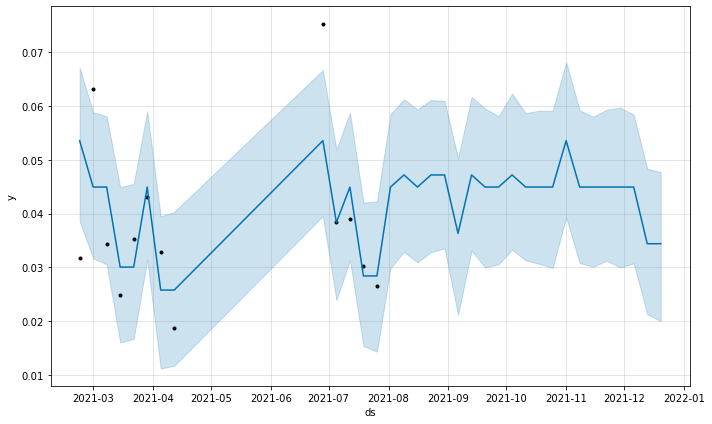

In [1642]:
fig = m.plot(forecast)

In [1643]:
df_doormat = forecast[['ds', 'yhat']]
df_doormat = df_doormat.merge(df[['ds','y']], how='left', on='ds')
df_doormat['y_merged'] = df_doormat.y.combine_first(df_doormat.yhat)

## OLD

### Doormat

In [1636]:
df = df_sales_FTS.loc[(df_sales_FTS['function']=='Doormat') &
                      (df_sales_FTS['texture']=='Bristle') &
                      (df_sales_FTS['size']=='2x3'),
                      ['week_begin_date',
                       'percent_of_total',
                       'total_rugs_sold',
                       'sale',
                       'launch',
                       'bfcm',
                       'anniversary',
                       'spring',
                       'email',
                       'doormat']].rename(columns={'week_begin_date': 'ds',
                                               'percent_of_total': 'y'})
df = df.merge(df_IndoorChenille, how='inner', on='ds')
df = df.rename(columns={'merged':'IndoorChenille_percentOfTotal'})

In [1637]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
#m.add_regressor('IndoorChenille_percentOfTotal')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('doormat')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 9.


In [1638]:
df_cv = cross_validation(m, initial='26 W', period='1 W', horizon = '1 W')

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.

In [1639]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000003,0.001655,0.001313,0.124861,0.085897,0.124058,0.285714
1,14 days,0.000004,0.001889,0.001563,0.141606,0.134046,0.152685,0.285714
2,21 days,0.000002,0.001318,0.001078,0.111313,0.104467,0.121167,0.285714
3,28 days,0.000006,0.002445,0.001938,0.206138,0.189498,0.191304,0.285714


In [1640]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                'doormat']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_IndoorChenille[['ds','merged']], on='ds').rename(columns={'merged': 'IndoorChenille_percentOfTotal'})

In [1641]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
29,2021-11-22,0.044938,0.031236,0.059326
30,2021-11-29,0.044938,0.029944,0.059742
31,2021-12-06,0.044938,0.030748,0.058394
32,2021-12-13,0.034388,0.021306,0.048358
33,2021-12-20,0.034388,0.019977,0.047733


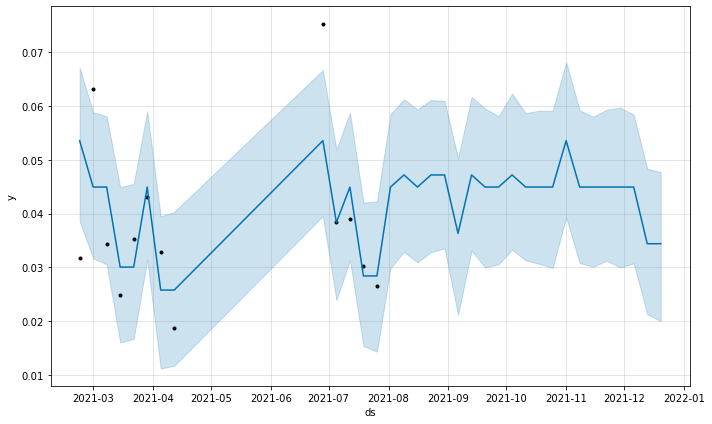

In [1642]:
fig = m.plot(forecast)

In [1643]:
df_doormat = forecast[['ds', 'yhat']]
df_doormat = df_doormat.merge(df[['ds','y']], how='left', on='ds')
df_doormat['y_merged'] = df_doormat.y.combine_first(df_doormat.yhat)

### Jute

In [1616]:
df = df_sales_FT.loc[(df_sales_FT['function']=='Outdoor') &
                     (df_sales_FT['texture']=='Jute'),
                     ['week_begin_date',
                      'percent_of_total',
                      'total_rugs_sold',
                      'sale',
                      'launch',
                      'bfcm',
                      'anniversary',
                      'spring',
                      'email']].rename(columns={'week_begin_date': 'ds',
                                                'percent_of_total': 'y'})

In [1631]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.06,
            growth='flat')

# add holidays and regressors
m.add_country_holidays(country_name='US')
#m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 7.


In [1624]:
df_cv = cross_validation(m, initial='52 W', period='1 W', horizon = '4 W')

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.

In [1625]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000003,0.001655,0.001313,0.124861,0.085897,0.124058,0.285714
1,14 days,0.000004,0.001889,0.001563,0.141606,0.134046,0.152685,0.285714
2,21 days,0.000002,0.001318,0.001078,0.111313,0.104467,0.121167,0.285714
3,28 days,0.000006,0.002445,0.001938,0.206138,0.189498,0.191304,0.285714


In [1632]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_top_line[['ds','y_merged']], on='ds').rename(columns={'y_merged': 'total_rugs_sold'})

In [1633]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2021-11-22,0.021382,0.018555,0.023971
28,2021-11-29,0.021382,0.018738,0.024108
29,2021-12-06,0.021382,0.018544,0.024298
30,2021-12-13,0.020605,0.017962,0.023326
31,2021-12-20,0.020605,0.018065,0.023180


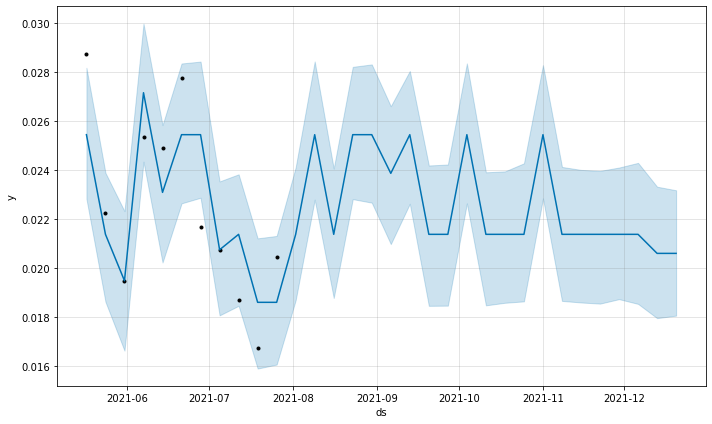

In [1634]:
fig = m.plot(forecast)

In [1652]:
df_Jute = forecast[['ds', 'yhat']]
df_Jute = df_Jute.merge(df[['ds','y']], how='left', on='ds')
df_Jute['y_merged'] = df_Jute.y.combine_first(df_Jute.yhat)
df_Jute = df_Jute.rename(columns={'yhat':'forecast',
                                  'y':'actual',
                                  'y_merged':'merged'})

#### 2.5x7

In [1654]:
df = df_sales_FTS.loc[(df_sales_FTS['function']=='Outdoor') &
                      (df_sales_FTS['texture']=='Jute') &
                      (df_sales_FTS['size']=='2.5x7'),
                      ['week_begin_date',
                       'percent_of_total',
                       'total_rugs_sold',
                       'sale',
                       'launch',
                       'bfcm',
                       'anniversary',
                       'spring',
                       'email',
                       'runner']].rename(columns={'week_begin_date': 'ds',
                                                  'percent_of_total': 'y'})
df = df.merge(df_Jute, how='inner', on='ds')
df = df.rename(columns={'merged':'Jute_percentOfTotal'})

In [1660]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
#m.add_country_holidays(country_name='US')
m.add_regressor('Jute_percentOfTotal')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('runner')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 7.


In [1661]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                'runner']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_IndoorPlush[['ds','merged']], on='ds').rename(columns={'merged': 'Jute_percentOfTotal'})

In [1662]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2021-11-22,0.005245,0.003966,0.006518
28,2021-11-29,0.004323,0.003143,0.005471
29,2021-12-06,0.004515,0.003353,0.005722
30,2021-12-13,0.004370,0.003091,0.005595
31,2021-12-20,0.004445,0.003052,0.005721


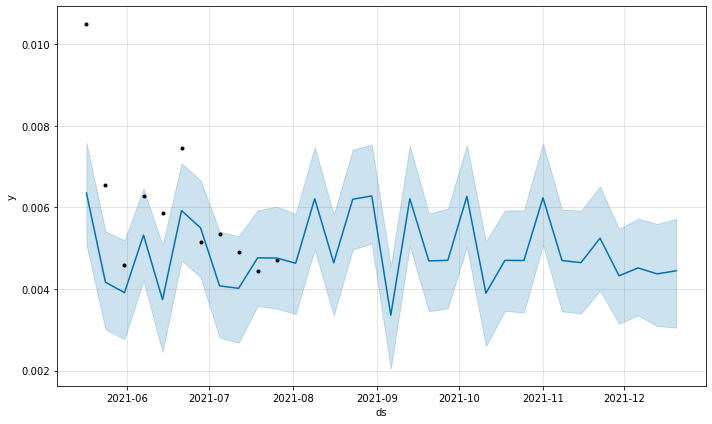

In [1663]:
fig = m.plot(forecast)

In [1664]:
df_2x7_jute = forecast[['ds', 'yhat']]
df_2x7_jute = df_2x7_jute.merge(df[['ds','y']], how='left', on='ds')
df_2x7_jute['y_merged'] = df_2x7_jute.y.combine_first(df_2x7_jute.yhat)

#### 2.5x10

In [1665]:
df = df_sales_FTS.loc[(df_sales_FTS['function']=='Outdoor') &
                      (df_sales_FTS['texture']=='Jute') &
                      (df_sales_FTS['size']=='2.5x10'),
                      ['week_begin_date',
                       'percent_of_total',
                       'total_rugs_sold',
                       'sale',
                       'launch',
                       'bfcm',
                       'anniversary',
                       'spring',
                       'email',
                       'runner']].rename(columns={'week_begin_date': 'ds',
                                                  'percent_of_total': 'y'})
df = df.merge(df_Jute, how='inner', on='ds')
df = df.rename(columns={'merged':'Jute_percentOfTotal'})

In [1666]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
#m.add_country_holidays(country_name='US')
m.add_regressor('Jute_percentOfTotal')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('runner')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 7.


In [1667]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                'runner']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_IndoorPlush[['ds','merged']], on='ds').rename(columns={'merged': 'Jute_percentOfTotal'})

In [1668]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26,2021-11-22,0.003428,0.002770,0.004052
27,2021-11-29,0.003209,0.002623,0.003881
28,2021-12-06,0.003254,0.002628,0.003908
29,2021-12-13,0.003151,0.002503,0.003785
30,2021-12-20,0.003169,0.002533,0.003817


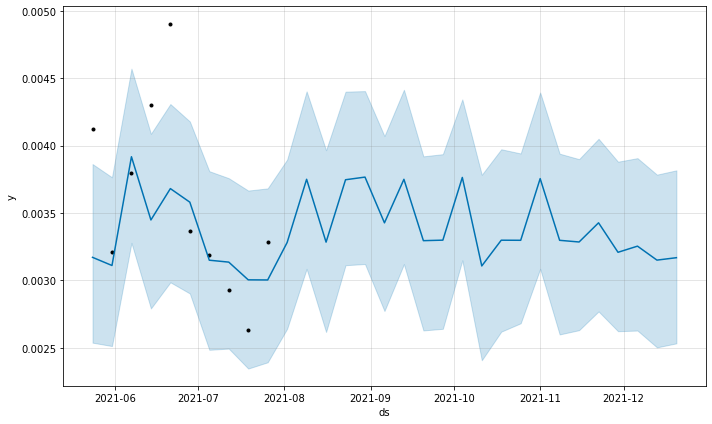

In [1669]:
fig = m.plot(forecast)

In [1670]:
df_2x10_jute = forecast[['ds', 'yhat']]
df_2x10_jute = df_2x10_jute.merge(df[['ds','y']], how='left', on='ds')
df_2x10_jute['y_merged'] = df_2x10_jute.y.combine_first(df_2x10_jute.yhat)

#### 3x5

In [1671]:
df = df_sales_FTS.loc[(df_sales_FTS['function']=='Outdoor') &
                      (df_sales_FTS['texture']=='Jute') &
                      (df_sales_FTS['size']=='3x5'),
                      ['week_begin_date',
                       'percent_of_total',
                       'total_rugs_sold',
                       'sale',
                       'launch',
                       'bfcm',
                       'anniversary',
                       'spring',
                       'email',
                       '3x5']].rename(columns={'week_begin_date': 'ds',
                                                  'percent_of_total': 'y'})
df = df.merge(df_Jute, how='inner', on='ds')
df = df.rename(columns={'merged':'Jute_percentOfTotal'})

In [1672]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
#m.add_country_holidays(country_name='US')
m.add_regressor('Jute_percentOfTotal')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('3x5')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 7.


In [1673]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                '3x5']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_IndoorPlush[['ds','merged']], on='ds').rename(columns={'merged': 'Jute_percentOfTotal'})

In [1674]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26,2021-11-22,0.007800,0.006583,0.008913
27,2021-11-29,0.008032,0.006858,0.009237
28,2021-12-06,0.007984,0.006828,0.009130
29,2021-12-13,0.007931,0.006813,0.009075
30,2021-12-20,0.007912,0.006760,0.009110


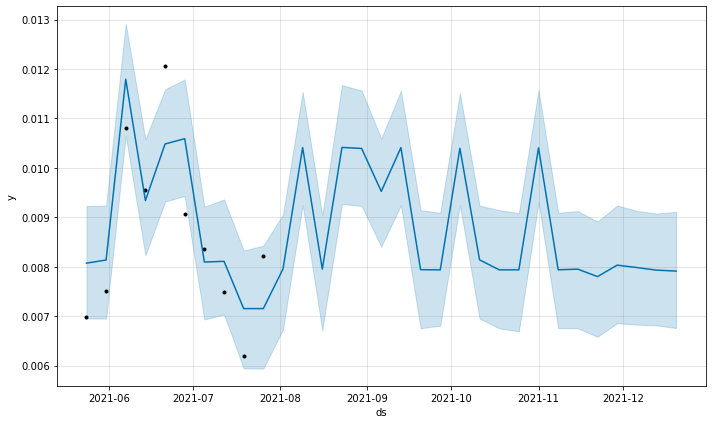

In [1675]:
fig = m.plot(forecast)

In [1676]:
df_3x5_jute = forecast[['ds', 'yhat']]
df_3x5_jute = df_3x5_jute.merge(df[['ds','y']], how='left', on='ds')
df_3x5_jute['y_merged'] = df_3x5_jute.y.combine_first(df_3x5_jute.yhat)

#### 5x7

In [1690]:
df = df_sales_FTS.loc[(df_sales_FTS['function']=='Outdoor') &
                      (df_sales_FTS['texture']=='Jute') &
                      (df_sales_FTS['size']=='5x7'),
                      ['week_begin_date',
                       'percent_of_total',
                       'total_rugs_sold',
                       'sale',
                       'launch',
                       'bfcm',
                       'anniversary',
                       'spring',
                       'email',
                       '5x7']].rename(columns={'week_begin_date': 'ds',
                                                  'percent_of_total': 'y'})
df = df.merge(df_Jute, how='inner', on='ds')
df = df.rename(columns={'merged':'Jute_percentOfTotal'})

In [1691]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
#m.add_country_holidays(country_name='US')
m.add_regressor('Jute_percentOfTotal')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
#m.add_regressor('spring')
#m.add_regressor('email')
#m.add_regressor('5x7')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 7.


In [1692]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                '5x7']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_IndoorPlush[['ds','merged']], on='ds').rename(columns={'merged': 'Jute_percentOfTotal'})

In [1693]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
26,2021-11-22,0.004104,0.003404,0.004830
27,2021-11-29,0.003849,0.003149,0.004638
28,2021-12-06,0.003902,0.003139,0.004731
29,2021-12-13,0.004000,0.003283,0.004731
30,2021-12-20,0.004021,0.003245,0.004815


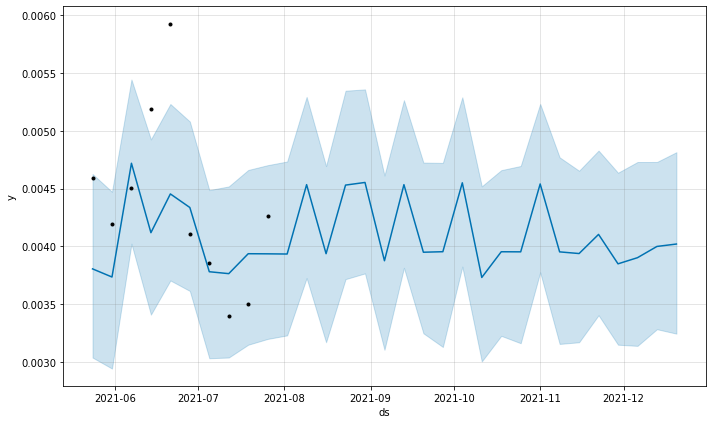

In [1694]:
fig = m.plot(forecast)

In [1695]:
df_5x7_jute = forecast[['ds', 'yhat']]
df_5x7_jute = df_5x7_jute.merge(df[['ds','y']], how='left', on='ds')
df_5x7_jute['y_merged'] = df_5x7_jute.y.combine_first(df_5x7_jute.yhat)

### Pad Only

In [1707]:
df = df_sales_FT.loc[(df_sales_FT['function']=='NUL') &
                     (df_sales_FT['texture']=='Rubber pad'),
                     ['week_begin_date',
                      'percent_of_total',
                      'total_rugs_sold',
                      'sale',
                      'launch',
                      'bfcm',
                      'anniversary',
                      'spring',
                      'email']].rename(columns={'week_begin_date': 'ds',
                                                'percent_of_total': 'y'})

In [1715]:
# specify model parameters
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            changepoint_prior_scale=0.06)

# add holidays and regressors
m.add_country_holidays(country_name='US')
#m.add_regressor('total_rugs_sold')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')

# train model
m.fit(df)

In [1716]:
df_cv = cross_validation(m, initial='105 W', period='4 W', horizon = '12 W')

INFO:prophet:Making 4 forecasts with cutoffs between 2021-02-08 00:00:00 and 2021-05-03 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

In [1717]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,7 days,0.000006,0.002387,0.001933,0.153952,0.108958,0.137189,0.75
1,14 days,0.000018,0.004185,0.003377,0.167537,0.141207,0.187299,0.50
2,21 days,0.000011,0.003335,0.002907,0.172386,0.187126,0.183471,0.50
3,28 days,0.000004,0.002023,0.001562,0.109820,0.089831,0.100596,0.75
4,35 days,0.000008,0.002894,0.002351,0.185440,0.136288,0.161332,0.75


In [1718]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_top_line[['ds','y_merged']], on='ds').rename(columns={'y_merged': 'total_rugs_sold'})

In [1719]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
147,2021-11-22,0.012409,0.008921,0.015374
148,2021-11-29,0.016399,0.013421,0.019320
149,2021-12-06,0.027953,0.024861,0.031140
150,2021-12-13,0.023011,0.019861,0.025873
151,2021-12-20,0.018391,0.015220,0.021658


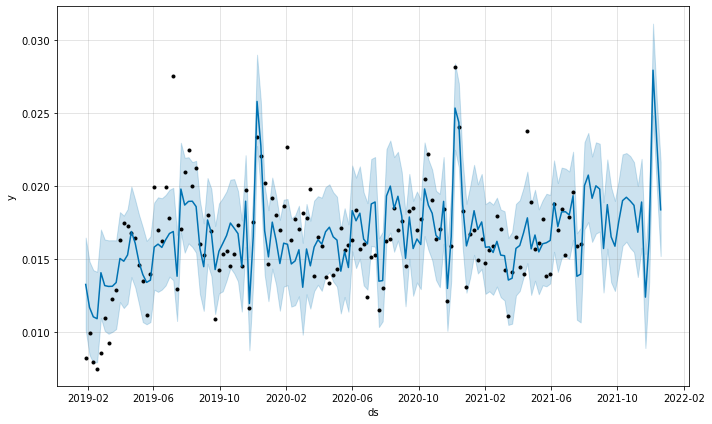

In [1720]:
fig = m.plot(forecast)

In [1721]:
df_Pad = forecast[['ds', 'yhat']]
df_Pad = df_Pad.merge(df[['ds','y']], how='left', on='ds')
df_Pad['y_merged'] = df_Pad.y.combine_first(df_Pad.yhat)
df_Pad = df_Pad.rename(columns={'yhat':'forecast',
                                  'y':'actual',
                                  'y_merged':'merged'})

#### 2.5x7

In [1654]:
df = df_sales_FTS.loc[(df_sales_FTS['function']=='NUL') &
                      (df_sales_FTS['texture']=='Rubber pad') &
                      (df_sales_FTS['size']=='2.5x7'),
                      ['week_begin_date',
                       'percent_of_total',
                       'total_rugs_sold',
                       'sale',
                       'launch',
                       'bfcm',
                       'anniversary',
                       'spring',
                       'email']].rename(columns={'week_begin_date': 'ds',
                                                  'percent_of_total': 'y'})
df = df.merge(df_Pad, how='inner', on='ds')
df = df.rename(columns={'merged':'Jute_percentOfTotal'})

In [1660]:
# specify model parameters
m = Prophet(yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat')

# add holidays and regressors
#m.add_country_holidays(country_name='US')
m.add_regressor('Jute_percentOfTotal')
m.add_regressor('sale',mode='multiplicative')
m.add_regressor('launch',mode='multiplicative')
m.add_regressor('bfcm',mode='multiplicative')
m.add_regressor('anniversary',mode='multiplicative')
m.add_regressor('spring')
m.add_regressor('email')
m.add_regressor('runner')

# train model
m.fit(df)

INFO:prophet:n_changepoints greater than number of observations. Using 7.


In [1661]:
future = m.make_future_dataframe(periods=52,freq = 'W-MON')
future = future.merge(df_event[['week_begin_date',
                                'sale',
                                'launch',
                                'bfcm',
                                'anniversary',
                                'spring',
                                'email',
                                'runner']],
                      left_on='ds', right_on='week_begin_date')
future = future.merge(df_IndoorPlush[['ds','merged']], on='ds').rename(columns={'merged': 'Jute_percentOfTotal'})

In [1662]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27,2021-11-22,0.005245,0.003966,0.006518
28,2021-11-29,0.004323,0.003143,0.005471
29,2021-12-06,0.004515,0.003353,0.005722
30,2021-12-13,0.004370,0.003091,0.005595
31,2021-12-20,0.004445,0.003052,0.005721


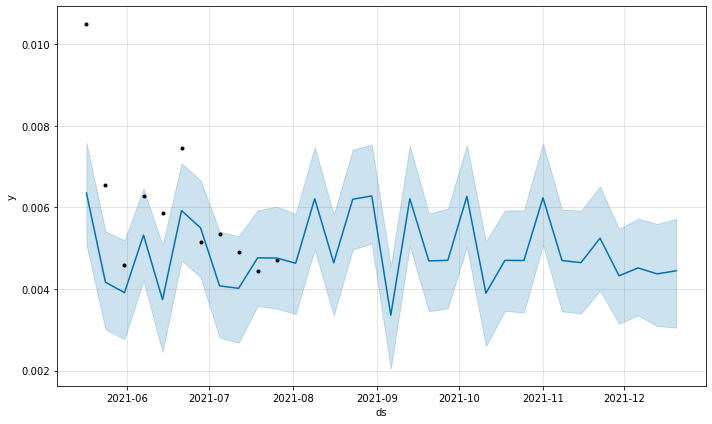

In [1663]:
fig = m.plot(forecast)

In [1664]:
df_2x7_jute = forecast[['ds', 'yhat']]
df_2x7_jute = df_2x7_jute.merge(df[['ds','y']], how='left', on='ds')
df_2x7_jute['y_merged'] = df_2x7_jute.y.combine_first(df_2x7_jute.yhat)

## Pushing granular forecasts to DW

In [1759]:
df_dates = df_top_line.loc[df_top_line['y'].isnull(),['ds']].copy()

In [1884]:
df_gdf = df_dates.merge(df_2x3[['ds','y_merged']], how="left", on='ds')
df_gdf['function'] = 'Indoor'
df_gdf['texture']  = 'Chenille'
df_gdf['size']     = '2x3'

df_gdf = df_gdf.append(df_3x5[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '3x5'

df_gdf = df_gdf.append(df_5x7[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '5x7'

df_gdf = df_gdf.append(df_6x9[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '6x9'

df_gdf = df_gdf.append(df_8x10[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '8x10'

df_gdf = df_gdf.append(df_9x12[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '9x12'

df_gdf = df_gdf.append(df_6round[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '6" Round'

df_gdf = df_gdf.append(df_8round[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '8" Round'

df_gdf = df_gdf.append(df_2x7_outdoor[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2.5x7'

df_gdf = df_gdf.append(df_2x10_outdoor[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2.5x10'

df_gdf = df_gdf.append(df_3x5_outdoor[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '3x5'

df_gdf = df_gdf.append(df_5x7_outdoor[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '5x7'

df_gdf = df_gdf.append(df_6x9_outdoor[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '6x9'

df_gdf = df_gdf.append(df_8x10_outdoor[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Chenille'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '8x10'

df_gdf = df_gdf.append(df_2x3_plush[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Plush'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2x3'

df_gdf = df_gdf.append(df_2x7_plush[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Plush'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2.5x7'

df_gdf = df_gdf.append(df_2x10_plush[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Plush'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2.5x10'

df_gdf = df_gdf.append(df_3x5_plush[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Plush'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '3x5'

df_gdf = df_gdf.append(df_5x7_plush[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Plush'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '5x7'

df_gdf = df_gdf.append(df_6x9_plush[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Indoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Plush'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '6x9'

df_gdf = df_gdf.append(df_doormat[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Doormat'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Bristle'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2x3'

df_gdf = df_gdf.append(df_2x7_jute[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Jute'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2.5x7'

df_gdf = df_gdf.append(df_2x10_jute[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Jute'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '2.5x10'

df_gdf = df_gdf.append(df_3x5_jute[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Jute'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '3x5'

df_gdf = df_gdf.append(df_5x7_jute[['ds','y_merged']])
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'Outdoor'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Jute'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = '5x7'

df_gdf = df_gdf.append(df_Pad[['ds','merged']].rename(columns = {'merged':'y_merged'}))
df_gdf.loc[df_gdf['function'].isnull(),'function'] = 'NUL'
df_gdf.loc[df_gdf['texture'].isnull(),'texture']   = 'Rubber pad'
df_gdf.loc[df_gdf['size'].isnull(),'size']         = 'NA'

In [1887]:
df_gdf['created_date'] = today.strftime("%Y-%m-%d")
df_gdf = df_gdf.rename(columns={'y_merged':'forecasted_percent_of_total',
                                'ds':'horizon_date'})
df_gdf.sort_values(by=['horizon_date','function','texture','size','created_date'],inplace=True)

In [1891]:
df_gdf = df_gdf.loc[df_gdf['horizon_date'] >= (today-timedelta(days=today.weekday())).strftime("%Y-%m-%d")]

In [1918]:
df_gdf.to_sql('gdf_outputs_test', engine, schema = 'temp_entities', index=False, if_exists='replace')

In [2315]:
df_gdf.loc[(df_gdf['size']=='2.5x7') &
           (df_gdf['function']=='Indoor') &
           (df_gdf['texture']=='Chenille')
          ]

,horizon_date,forecasted_percent_of_total,function,texture,size,created_date


In [2316]:
df_IndoorChenille

,ds,forecast,actual,merged
0,2019-01-07,1.001508,1.000000,1.000000
1,2019-01-14,1.002441,1.000000,1.000000
2,2019-01-21,1.002247,1.000000,1.000000
3,2019-01-28,1.001841,0.991727,0.991727
4,2019-02-04,0.996486,0.990070,0.990070
...,...,...,...,...
150,2021-11-22,0.904626,NaN,0.904626
151,2021-11-29,0.881116,NaN,0.881116
152,2021-12-06,0.864175,NaN,0.864175
153,2021-12-13,0.865708,NaN,0.865708
